In [1]:
import timeit
import import_ipynb
from RecombHistory import *
plt.rcParams['font.size'] = 12.0

from scipy.integrate import solve_ivp
from scipy.interpolate import CubicSpline
from scipy.interpolate import RectBivariateSpline

a_init = 1.0e-8
x_init = np.log(a_init)
x_end = np.log(1.0)

nk = 100

kmin = .1*H0/c
kmax = 1.0e3*H0/c

ks = np.zeros(nk)
for i in range(nk):
    ks[i] = kmin + (kmax - kmin)*(i/100.0)**2.0

lmaxint = 6
npar = 6 + lmaxint

ntight = 500
n_xtot = 1000

importing Jupyter notebook from RecombHistory.ipynb
importing Jupyter notebook from BackgroundCosmology.ipynb
The surface of last scattering occured at x_* = -6.85 and z_* = 938.66.

The half-way point of recombination occured at x_r = -7.12 and z_r = 1238.06.

Using only the Saha equation, the half-way point of recombination occured at x_r = -7.19 and z_r = 1326.77.



In [2]:
# Returns the time at which tight coupling ends.
# Either when (dτ < 10) OR (c*k/(Hp*dt) > .1) OR (x > x(recomb start))
def getTCtime(k):
    xstartrec = -np.log(1.0 + 1630.4)
    x = x_init
    
    while x < xstartrec:
        x = x + 1.0e-2
        
        hp = getHPrime(x)
        dτ = τ2spl(x)[0]
        eps = c*k/(hp*dτ)
        
        if ( (abs(dτ) < 10.0) or (abs(eps) > .1) or (x > xstartrec) ):
            xtc = x
            break
            
    return xtc

In [3]:
def yTCderivs(t, y):
    dydx = np.zeros(7)
    
    k0 = kcurrent
    
    a = np.exp(t)
    
    hp = getHPrime(t)
    dhp = getdHPrime(t)
    
    dτ = τ2spl(t)[0]
    ddτ = τ22spl(t)[0]
    
    R = 4.0*Ωr/(3.0*Ωb*a)
    ϵ = c*k/hp
    Θ2 = -20*ϵ*ytc[5]/(45.0*dτ)
    ψ = -ytc[4] - 12.0*H0**2.0*Ωr*Θ2/((c*k0*a)**2.0)
    
    # δ  = [0]
    # δb = [1]
    # v  = [2]
    # vb = [3]
    # dΦ = [4]
    # θ0 = [5]
    # θ1 = [6]
    
    # dΦ
    dydx[4] = ψ - (c**2.0*k0**2.0*ytc[4]/(3.0*hp**2.0)) + (H0**2.0/(2.0*hp**2.0))*(Ωm*ytc[0]/np.exp(t) + Ωb*ytc[1]/np.exp(t) + 4.0*Ωr*ytc[5]/np.exp(2.0*t))
    
    # dθ0
    dydx[5] = -c*k0*ytc[6]/hp - dydx[4]
    
    q = (-((1.0 - R)*dτ + (1.0 + R)*ddτ)*(3.0*ytc[6] + ytc[3]) - (c*k0/hp)*ψ + (1.0 - dhp/hp)*(c*k0/hp)*(-ytc[5] + 2.0*Θ2) - ((c*k0/hp)*dydx[5]))/((1.0 + R)*dτ + (dhp/hp) - 1.0)
    
    # dvb
    dydx[3] = (-ytc[3] - c*k0*ψ/hp + R*(q + c*k0*(-ytc[5] + 2.0*Θ2)/hp - c*k0*ψ/hp))/(1.0 + R)
    
    #dθ1
    dydx[6] = (q - dydx[3])/3.0
    
    # dv
    dydx[2] = -ytc[2] - c*k0*ψ/hp
    
    # dδ
    dydx[0] = c*k0*ytc[2]/hp - 3.0*dydx[4]
        
    # dδb
    dydx[1] = c*k0*ytc[3]/hp - 3.0*dydx[4]
    
    return dydx

In [4]:
def yderivs(t, y):
    dydx = np.zeros(npar)
    
    a = math.exp(t)
    
    k0 = kcurrent
    
    η = η_spline(t)
    
    hp = getHPrime(t)
    dhp = getdHPrime(t)
    
    dτ = τ2spl(t)[0]
    ddτ = τ22spl(t)[0]
    
    R = 4.0*Ωr/(3.0*Ωb*np.exp(t))
    
    ϵ = (c*k0)/hp
    
    ψ = -y[4] - 12.0*(H0/(c*k0*a))**2.0*Ωr*y[7]
    
    # δ  = [0]
    # δb = [1]
    # v  = [2]
    # vb = [3]
    # Φ  = [4]
    # θ0 = [5]
    # θ1 = [6]
    # Θl = [7->11]
    
    # dΦ
    dydx[4] = ψ - (ϵ**2.0*y[4])/3.0 + (H0**2.0/(2.0*hp**2.0))*(((Ωm*y[0])/a) + ((Ωb*y[1])/a) + ((4.0*Ωr*y[5])/(a**2.0)))
    
    # dδ
    dydx[0] = ϵ*y[2] - 3.0*dydx[4]

    # dδb
    dydx[1] = ϵ*y[3] - 3.0*dydx[4]
    
    # dv
    dydx[2] = -y[2] - ϵ*ψ

    # dvb
    dydx[3] = -y[3] - ϵ*ψ + dτ*R*(3.0*y[6] + y[3])
    
    # dθ0
    dydx[5] = -ϵ*y[6] - dydx[4]

    # dθ1
    dydx[6] = (ϵ/3.0)*y[5] - (2.0*ϵ/3.0)*y[7] + (ϵ/3.0)*ψ + dτ*(y[6] + (1.0/3.0)*y[3])
    
    # dθ2
    dydx[7] = (2.0*ϵ/5.0)*y[6] - (3.0/5.0)*ϵ*y[8] + dτ*(y[7] - .1*y[7])
    
    # dΘ3->5
    for l in range(3, lmaxint):
        dydx[5 + l] = ((l*ϵ*y[5 + l - 1])/(2.0*l + 1.0)) - (((l + 1.0)*ϵ*y[5 + l + 1])/((2.0*l + 1.0))) + (dτ*y[5 + l])
    
    # dΘ6
    dydx[npar - 1] = ϵ*y[npar - 2] - ((c*(lmaxint + 1.0)*y[npar - 1])/(hp*η)) + (dτ*y[npar - 1])
    
    return dydx

In [5]:
def yderivs_C_l(x, y):
    dydx = np.zeros(npar)
    
    k0 = kcurrent
    
    hp = getHPrime(x)
    dhp = getdHPrime(x)
    
    dτ = τ2spl(x)[0]
    ddτ = τ22spl(x)[0]
    
    R = 4.0*Ωr/(3.0*Ωb*math.exp(x))
    ψ = -y[4] - 12.0*H0**2.0*Ωr*y[7]/(c**2.0*k0**2.0*np.exp(2.0*x))
    
    # δ  = [0]
    # δb = [1]
    # v  = [2]
    # vb = [3]
    # Φ  = [4]
    # θ0 = [5]
    # θ1 = [6]
    # Θl = [7->11]
    
    # dΦ
    dydx[4] = ψ - c**2.0*k0**2.0*y[4]/(3.0*hp**2.0) + (H0**2.0/(2.0*hp**2.0))*(Ωm*y[0]/np.exp(x) + Ωb*y[1]/np.exp(x) + 4.0*Ωr*y[5]/np.exp(2.0*x))
    
    # dδ
    dydx[0] = c*k0*y[2]/hp - 3.0*dydx[4]

    # dδb
    dydx[1] = c*k0*y[3]/hp - 3.0*dydx[4]
    
    # dv
    dydx[2] = -y[2] - c*k0*ψ/hp

    # dvb
    dydx[3] = -y[3] - c*k0*ψ/hp + dτ*R*(3.0*y[6] + y[3])
    
    # dθ0
    dydx[5] = -c*k0*y[6]/hp - dydx[4]

    # dθ1
    dydx[6] = c*k0*y[5]/(3.0*hp) - 2.0*c*k0/(3.0*hp)*y[7] + c*k0*ψ/(3.0*hp) + dτ*(y[6] + (1.0/3.0)*y[3])
    
    # dΘ2->5
    for l in range(2, lmaxint):
        dydx[5 + l] = l*c*k0*y[5 + l - 1]/((2.0*l + 1.0)*hp) - (l + 1.0)*c*k0*y[5 + l + 1]/((2.0*l + 1.0)*hp) + dτ*(y[5 + l] -(1.0/10.0)*y[7])
    
    # dΘ6
    dydx[npar - 1] = c*k0*y[npar - 2]/hp - c*(lmaxint + 1)*y[npar - 1]/(hp*η_spline(x)) + dτ*y[npar - 1]
    
    return dydx

In [ ]:
'''
def source_function():
    S = np.zeros(shape = (n_grid, nk))
    
    for i in range(n_grid):
        g = gspl(x_grid[i])[0]
        dg = g2spl(x_grid[i])[0]
        ddg = g22spl(x_grid[i])[0]
        τ = τspl(x_grid[i])[0]
        dτ = τ2spl(x_grid[i])[0]
        ddτ = τ22spl(x_grid[i])[0]
        hp = getHPrime(x_grid[i])
        dhp = getdHPrime(x_grid[i])
        ddhhp = .5*H0**2.0*((Ωb + Ωm)/np.exp(x_grid[i]) + 4.0*Ωr/np.exp(2.0*x_grid[i]) + 4.0*ΩΛ*np.exp(2.0*x_grid[i]))
    
        for j in range(nk):
            Π = Θ[n_grid + i, 2, j]
            dΠ = dΘ[i, 2, j]
            ddΠ = .4*c*ks[j]*(-dhp*Θ[n_grid + i, 1, j]/hp + dΘ[i, 1, j])/hp + .3*(ddτ*Π + dτ*dΠ) - (.6*c*ks[j]/hp)*((-dhp/hp)*Θ[n_grid + i, 3, j] + dΘ[i, 3, j])
            
            part1 = g*(Θ[n_grid + i, 0, j] + Ψ[n_grid + i, j] + Π/4.0)
            part2 = np.exp(-τ)*(dΨ[i, j] - dΦ[i, j])
            part3 = -(1.0/(c*ks[j]))*(g*vb[n_grid + i, j]*dhp + g*hp*dvb[i, j] + hp*vb[n_grid + i, j]*dg)
            part4 = ((3.0/4.0)/(c**2.0*ks[j]**2.0))*(ddhhp*g*Π + 3.0*hp*dhp*(dg*Π + g*dΠ) + hp**2.0*(ddg*Π + 2.0*dg*dΠ + g*ddΠ))
            
            S[i, j] = part1 + part2 + part3 + part4
        
    ks_high_res = np.exp(np.linspace(np.log(kmin), np.log(kmax), num=n_high_res))
        
    xstartrec = -np.log(1.0 + 1630.4)
    x_grid_high_res = np.linspace(xstartrec, x_end, n_high_res, endpoint=True)
        
        
    S_spl = RectBivariateSpline(x_grid_high_res, ks_high_res, S)
        
    return S_spl, x_high_res, ks_high_res
'''

In [ ]:
Θ = np.zeros(shape=(n_xtot, lmaxint, nk))
dΘ = np.zeros(shape=(n_t, lmaxint, nk))

δ = np.zeros(shape=(n_xtot, nk))
δb = np.zeros(shape=(n_xtot, nk))

v = np.zeros(shape=(n_xtot, nk))
vb = np.zeros(shape=(n_xtot, nk))
dvb = np.zeros(shape=(n_t, nk))

Φ = np.zeros(shape=(n_xtot, nk))
dΦ = np.zeros(shape=(n_t, nk))

Ψ = np.zeros(shape=(n_xtot, nk))
dΨ = np.zeros(shape=(n_t, nk))

# Set up initial conditions for Boltzmann and Einstein equations
Φ[0, :] = 1.0
δ[0, :] = (3.0/2.0)*Φ[0, :]
δb[0, :] = δ[0, :]
Θ[0, 0, :] = (1.0/2.0)*Φ[0, :]

hp = getHPrime(x_init)
dτ = τ2spl(x_init)[0]

for i in range(nk):
    v[0, i] = c*ks[i]*Φ[0, i]/(2.0*hp)
    vb[0, i] = v[0, i]
    
    Θ[0, 1, i] = -c*ks[i]*Φ[0, i]/(6.0*hp)
    Θ[0, 2, i] = -20.0*c*ks[i]*Θ[0, 1, i]/(45.0*hp*dτ)

    for l in range(3, lmaxint):
        Θ[0, l, i] = -(l/(2.0*l + 1.0))*(c*ks[i]/(hp*dτ))*Θ[0, l - 1, i]


    Ψ[0, i] = -Φ[0, i] - 12.0*(H0/(c*ks[i]*a_init))**2.0*Ωr*Θ[0, 2, i]

In [111]:
def structure_solve():
    start = timeit.default_timer()

    y = np.zeros(npar)
    ytc = np.zeros(7) #y tight coupling - ytc

    x_grid = np.linspace(x_init, x_end, n_xtot)

    # Propogate each k-mode independently
    for k in range(nk):
        kcurrent = ks[k]

        ytc[0] = δ[0, k]
        ytc[1] = δb[0, k]
        ytc[2] = v[0, k]
        ytc[3] = vb[0, k]
        ytc[4] = Φ[0, k]
        ytc[5] = Θ[0, 0, k]
        ytc[6] = Θ[0, 1, k]

        # Find the time at which tight couplint (TC) is assumed
        #  and integrate equations to that time
        xtc = getTCtime(kcurrent)

        x_brec = np.linspace(x_init, xtc, ntight)
        x_full = np.linspace(xtc, x_end, 1000 - ntight)

        #if ((np.abs(xtc) - np.abs(x_t[0])) < 1.0e-3):
        #    xtc = x_t[0]
        #    x_condit = 1
        #xtc = -7.601402334583733
        #xtc = -15.0

        if k%25==0:
            print('------------------------------')
            print('k:', k)
            print('xtc:', xtc)

        # Solve during tight coupling regime
        sol_tight = solve_ivp(yTCderivs, [x_init, xtc], ytc, t_eval=x_brec, rtol=1e-6, atol=1e-6)

        # Set initial conditions for after tight coupling integration
        y_after_tc = sol_tight.y[:, -1]

        for j in range(7):
            y[j] = y_after_tc[j]

        # Θ2
        y[7] = -20.0*c*kcurrent*y[6]/(45.0*getHPrime(x_brec[-1])*τ2spl(x_brec[-1])[0])

        for l in range(2, lmaxint):
            y[6 + l] = -l*c*kcurrent*y[6 + l - 1]/((2.0*l + 1)*getHPrime(x_brec[-1])*τ2spl(x_brec[-1])[0])*Θ[ntight - 1, l - 1, k]

        # Solve after tight coupling to today
        sol_full = solve_ivp(yderivs, [x_full[0], x_full[-1]], y, t_eval=x_full, rtol=1e-6, atol=1e-6)

        for i in range(len(x_full)):        
            for l in range(lmaxint):
                Θ[ntight + i, l, k] =  sol_full.y[6 + l - 1, i]

        for i in range(len(x_full)):
            deriv_C_ls = yderivs_C_l(x_full[i], y)
        
            dΦ[i, k] = deriv_C_ls[4]
            dvb[i, k] = deriv_C_ls[3]
            dΘ[i, :, k] = deriv_C_ls[6:npar]
            dΨ[i, k] = -dΦ[0, k] + 12.0*H0**2.0*Ωr*Θ[i, 2, k]/(c**2.0*kcurrent**2.0*np.exp(2.0*x_full[i]))


        cur_δ = np.concatenate((sol_tight.y[0], sol_full.y[0]))
        cur_δb = np.concatenate((sol_tight.y[1], sol_full.y[1]))
        cur_v = np.concatenate((sol_tight.y[2], sol_full.y[2]))
        cur_vb = np.concatenate((sol_tight.y[3], sol_full.y[3]))
        cur_Φ = np.concatenate((sol_tight.y[4], sol_full.y[4]))
        cur_Θ0 = np.concatenate((sol_tight.y[5], sol_full.y[5]))
        cur_Θ1 = np.concatenate((sol_tight.y[6], sol_full.y[6]))

        δ[:, k] = cur_δ
        δb[:, k] = cur_δb
        v[:, k] = cur_v
        vb[:, k] = cur_vb
        Φ[:, k] = cur_Φ
        Θ[:, 0, k] = cur_Θ0
        Θ[:, 1, k] = cur_Θ1

        for i in range(1, ntight):
            Ψ[i, k] = -Φ[i, k] - 12.0*(H0/(c*kcurrent*np.exp(x_brec[i])))**2.0*Ωr*Θ[i, 2, k]
        for i in range(len(x_full)):
            Ψ[ntight + i, k] = -Φ[ntight + i, k] - 12.0*(H0/(c*kcurrent*math.exp(x_full[i])))**2.0*Ωr*Θ[ntight + i, 2, k]

    stop = timeit.default_timer()
    print('Time:', stop - start)

    δ_spl = RectBivariateSpline(x_grid, ks, δ)
    δb_spl = RectBivariateSpline(x_grid, ks, δb)
    v_spl = RectBivariateSpline(x_grid, ks, v)
    vb_spl = RectBivariateSpline(x_grid, ks, vb)
    Φ_spl = RectBivariateSpline(x_grid, ks, Φ)
    Ψ_spl = RectBivariateSpline(x_grid, ks, Ψ)
    Θ0_spl = RectBivariateSpline(x_grid, ks, Θ[:, 0, :])
    Θ1_spl = RectBivariateSpline(x_grid, ks, Θ[:, 1, :])
    Θ2_spl = RectBivariateSpline(x_grid, ks, Θ[:, 2, :])
    
    return

------------------------------
k: 0
xtc: -7.3866929783249


BackgroundCosmology.ipynb:7: RuntimeWarning: overflow encountered in exp
  "outputs": [],
BackgroundCosmology.ipynb:10: RuntimeWarning: overflow encountered in exp
  "import numpy as np\n",
BackgroundCosmology.ipynb:10: RuntimeWarning: invalid value encountered in double_scalars
  "import numpy as np\n",
C:\Users\Alexander\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in double_scalars
C:\Users\Alexander\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in exp


sol_full.y (12, 500)
sol_full.y (12, 500)
sol_full.y (12, 500)
sol_full.y (12, 500)
sol_full.y (12, 500)
------------------------------
k: 5
xtc: -7.3866929783249
sol_full.y (12, 500)
sol_full.y (12, 500)
sol_full.y (12, 500)
sol_full.y (12, 500)
sol_full.y (12, 500)
------------------------------
k: 10
xtc: -7.3866929783249
sol_full.y (12, 500)
sol_full.y (12, 500)
sol_full.y (12, 500)
sol_full.y (12, 500)
sol_full.y (12, 500)
------------------------------
k: 15
xtc: -7.3866929783249
sol_full.y (12, 500)
sol_full.y (12, 500)
sol_full.y (12, 500)
sol_full.y (12, 500)
sol_full.y (12, 500)
------------------------------
k: 20
xtc: -7.3866929783249
sol_full.y (12, 500)
sol_full.y (12, 500)
sol_full.y (12, 500)
sol_full.y (12, 500)
sol_full.y (12, 500)
------------------------------
k: 25
xtc: -7.3866929783249
sol_full.y (12, 500)
sol_full.y (12, 500)
sol_full.y (12, 500)
sol_full.y (12, 500)
sol_full.y (12, 500)
------------------------------
k: 30
xtc: -7.3866929783249
sol_full.y (12, 5

In [ ]:
def plot_spline(kvals):
    clr = ['r', 'b', 'g', 'k']
    
    fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(16, 20))
    
    axs[0, 0].set_title('Density Perturbations')
    axs[0, 0].set_xlim(-16, 0)
    for i in range(len(kvals)):
        lb = 'k = ' + str('{:05.4f}'.format(kvals[i]*Mpc)) + '/Mpc'
        data_δ = δ_spl(x_grid, kvals[i])[:, 0]
        axs[0, 0].plot(x_grid, np.abs(data_δ)/Mpc, color=clr[i], label=lb)
        data_δb = δb_spl(x_grid, kvals[i])[:, 0]
        axs[0, 0].plot(x_grid, np.abs(data_δb)/Mpc, color=clr[i], ls='--')
    axs[0, 0].set_xlabel('x = ln(a)')
    axs[0, 0].set_ylabel('δ')
    axs[0, 0].legend()
    
    
    axs[0, 1].set_title('Evolution of Velocity Perturbations')
    axs[0, 1].set_xlim(-16, 0)
    for i in range(len(kvals)):
        lb = 'k = ' + str('{:05.3f}'.format(kvals[i]*Mpc)) + '/Mpc'
        data_v = v_spl(x_grid, kvals[i])[:, 0]
        axs[0, 1].plot(x_grid, np.abs(data_v)/Mpc, color=clr[i], label=lb)
        data_vb = vb_spl(x_grid, kvals[i])[:, 0]
        axs[0, 1].plot(x_grid, np.abs(data_vb)/Mpc, color=clr[i], ls='--')
        data_Θ1 = Θ1_spl(x_grid, kvals[i])[:, 0]
        axs[0, 1].plot(x_grid, -3.0*data_Θ1/Mpc, color=clr[i], ls=':')
    axs[0, 1].set_xlabel('x')
    axs[0, 1].set_ylabel('$v_{CDM}$ (solid), $v_{b}$ (dashed), $v_{\gamma}$ = -3$Θ_1$ (dotted)')
    axs[0, 1].legend()
    
    
    axs[1, 0].set_title('Evolution of Effective Photon Temperature Perturbation')
    axs[1, 0].set_xlim(-16, 0)
    for i in range(len(kvals)):
        lb = 'k = ' + str('{:05.3f}'.format(kvals[i]*Mpc)) + '/Mpc'
        data_Θ0 = Θ0_spl(x_grid, kvals[i])[:, 0]
        data_Ψ = Ψ_spl(x_grid, kvals[i])[:, 0]
        axs[1, 0].plot(x_grid, np.abs(data_Θ0)/Mpc + data_Ψ/Mpc, color=clr[i], label=lb)
    axs[1, 0].set_xlabel('x')
    axs[1, 0].set_ylabel('$Θ^{eff}$ = $Θ_0$ + Ψ')
    axs[1, 0].legend()
    
    axs[1, 1].set_title('Ψ')
    axs[1, 1].set_xlim(-16, 0)
    for i in range(len(kvals)):
        lb = 'k = ' + str('{:05.3f}'.format(kvals[i]*Mpc)) + '/Mpc'
        data_Ψ = Ψ_spl(x_grid, kvals[i])[:, 0]
        axs[1, 1].plot(x_grid, data_Ψ/Mpc, color=clr[i], label=lb)
    axs[1, 1].set_xlabel('x')
    axs[1, 1].set_ylabel('Ψ')
    axs[1, 1].legend()
    
    axs[2, 0].set_title('Evolution of the Newtonian Potential')
    axs[2, 0].set_xlim(-16, 0)
    for i in range(len(kvals)):
        lb = 'k = ' + str('{:05.3f}'.format(kvals[i]*Mpc)) + '/Mpc'
        data_Φ = Φ_spl(x_grid, kvals[i])[:, 0]
        axs[2, 0].plot(x_grid, data_Φ/Mpc, color=clr[i], label=lb)
    axs[2, 0].set_xlabel('x')
    axs[2, 0].set_ylabel('Φ')
    axs[2, 0].legend()
    
    axs[2, 1].set_title('Evolution of the Anistropic Stress')
    axs[2, 1].set_xlim(-16, 0)
    for i in range(len(kvals)):
        lb = 'k = ' + str('{:05.3f}'.format(kvals[i]*Mpc)) + '/Mpc'
        data_Ψ = Ψ_spl(x_grid, kvals[i])[:, 0]
        data_Φ = Φ_spl(x_grid, kvals[i])[:, 0]
        axs[2, 1].plot(x_grid, data_Ψ/Mpc + data_Φ/Mpc, color=clr[i], label=lb)
    axs[2, 1].set_xlabel('x')
    axs[2, 1].set_ylabel('Φ + Ψ')
    axs[2, 1].legend()
    
    axs[3, 0].set_title('$Θ_0$')
    axs[3, 0].set_xlim(-16, 0)
    for i in range(len(kvals)):
        lb = 'k = ' + str('{:05.3f}'.format(kvals[i]*Mpc)) + '/Mpc'
        data_Θ0 = Θ0_spl(x_grid, kvals[i])[:, 0]
        axs[3, 0].plot(x_grid, data_Θ0/Mpc, color=clr[i], label=lb)
    axs[3, 0].set_xlabel('x')
    axs[3, 0].set_ylabel('$Θ_0$')
    axs[3, 0].legend()
    
    axs[3, 1].set_title('$Θ_1$')
    axs[3, 1].set_xlim(-16, 0)
    for i in range(len(kvals)):
        lb = 'k = ' + str('{:05.3f}'.format(kvals[i]*Mpc)) + '/Mpc'
        data_Θ1 = Θ1_spl(x_grid, kvals[i])[:, 0]
        axs[3, 1].plot(x_grid, data_Θ1/Mpc, color=clr[i], label=lb)
    axs[3, 1].set_xlabel('x')
    axs[3, 1].set_ylabel('$Θ_1$')
    axs[3, 1].legend()
    
    fig.tight_layout()
    plt.show()
    
k_factor = 1.0
kvals = [ks[0]*k_factor, ks[32]*k_factor, ks[66]*k_factor, ks[-1]*k_factor]
#plot_spline(kvals)

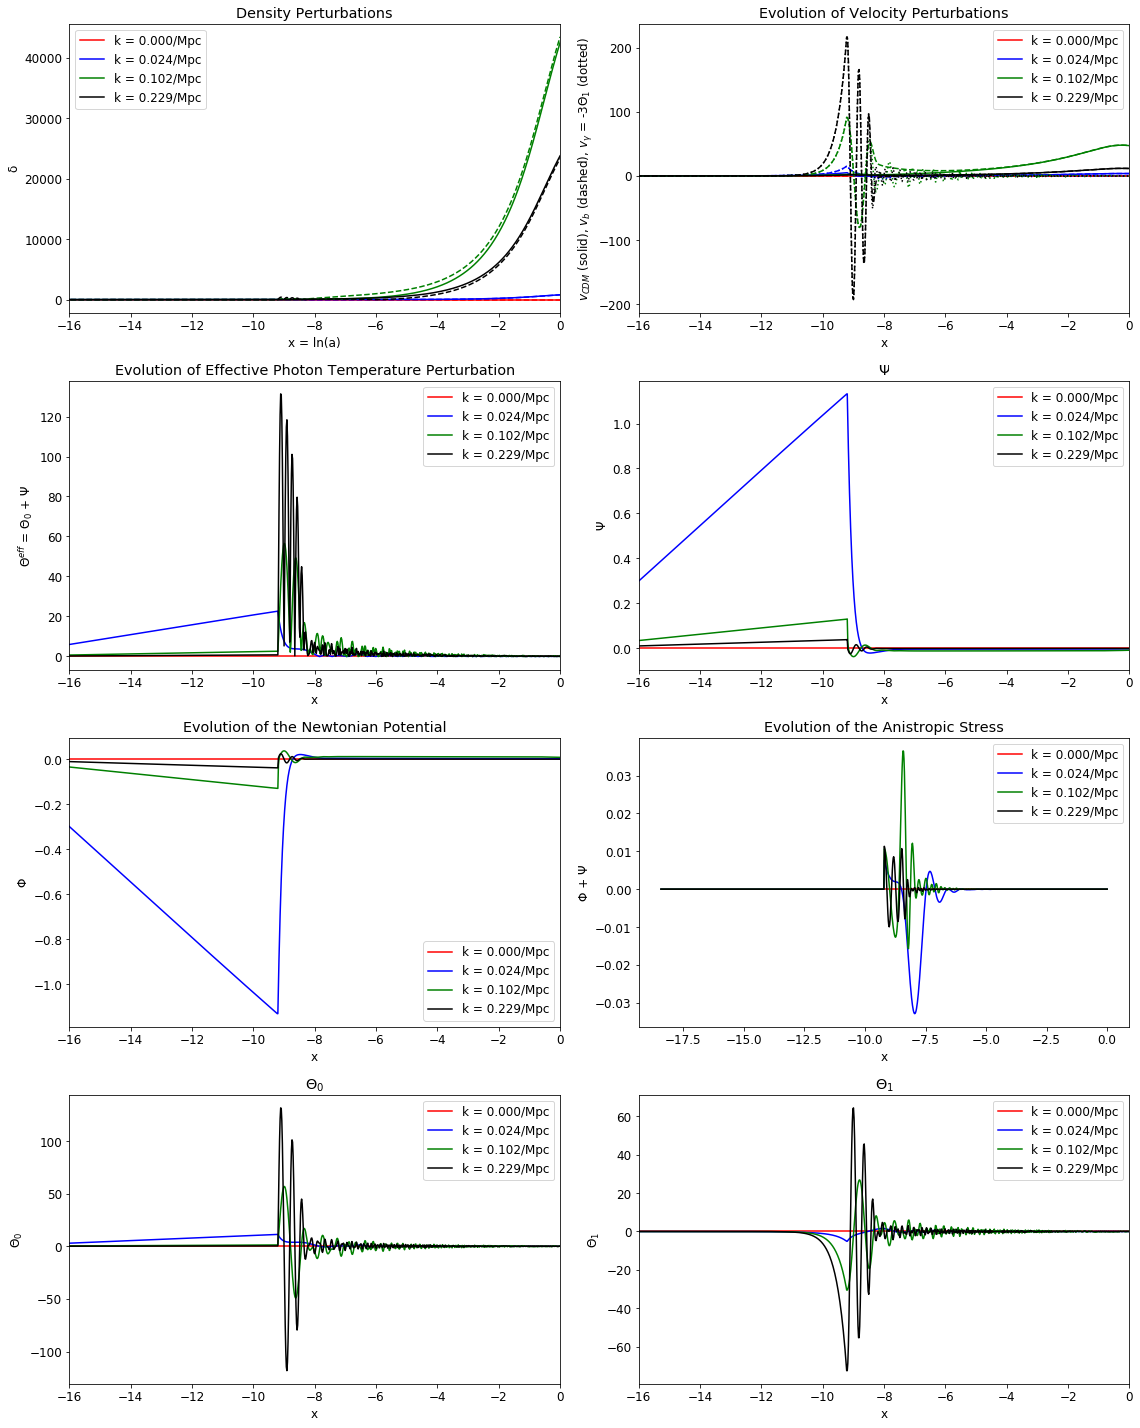

In [147]:
def plot_grid(kv):
    clr = ['r', 'b', 'g', 'k']
    
    fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(16, 20))
    
    axs[0, 0].set_title('Density Perturbations')
    axs[0, 0].set_xlim(-16, 0)
    for i in range(len(kv)):
        lb = 'k = ' + str('{:05.3f}'.format(ks[kv[i]]*Mpc)) + '/Mpc'
        axs[0, 0].plot(x_grid, np.abs(δ[:, kv[i]])/Mpc, color=clr[i], label=lb)
        axs[0, 0].plot(x_grid, np.abs(δb[:, kv[i]])/Mpc, color=clr[i], ls='--')
    axs[0, 0].set_xlabel('x = ln(a)')
    axs[0, 0].set_ylabel('δ')
    axs[0, 0].legend()
    
    
    axs[0, 1].set_title('Evolution of Velocity Perturbations')
    axs[0, 1].set_xlim(-16, 0)
    for i in range(len(kv)):
        lb = 'k = ' + str('{:05.3f}'.format(ks[kv[i]]*Mpc)) + '/Mpc'
        axs[0, 1].plot(x_grid, v[:, kv[i]]/Mpc, color=clr[i], label=lb)
        axs[0, 1].plot(x_grid, vb[:, kv[i]]/Mpc, color=clr[i], ls='--')
        axs[0, 1].plot(x_grid, -3.0*Θ[:, 1, kv[i]]/Mpc, color=clr[i], ls=':')
    axs[0, 1].set_xlabel('x')
    axs[0, 1].set_ylabel('$v_{CDM}$ (solid), $v_{b}$ (dashed), $v_{\gamma}$ = -3$Θ_1$ (dotted)')
    axs[0, 1].legend()
    
    
    axs[1, 0].set_title('Evolution of Effective Photon Temperature Perturbation')
    axs[1, 0].set_xlim(-16, 0)
    for i in range(len(kv)):
        lb = 'k = ' + str('{:05.3f}'.format(ks[kv[i]]*Mpc)) + '/Mpc'
        axs[1, 0].plot(x_grid, np.abs(Θ[:, 0, kv[i]])/Mpc + Ψ[:, kv[i]]/Mpc, color=clr[i], label=lb)
    axs[1, 0].set_xlabel('x')
    axs[1, 0].set_ylabel('$Θ^{eff}$ = $Θ_0$ + Ψ')
    axs[1, 0].legend()
    
    axs[1, 1].set_title('Ψ')
    axs[1, 1].set_xlim(-16, 0)
    for i in range(len(kv)):
        lb = 'k = ' + str('{:05.3f}'.format(ks[kv[i]]*Mpc)) + '/Mpc'
        axs[1, 1].plot(x_grid, Ψ[:, kv[i]]/Mpc, color=clr[i], label=lb)
    axs[1, 1].set_xlabel('x')
    axs[1, 1].set_ylabel('Ψ')
    axs[1, 1].legend()
    
    axs[2, 0].set_title('Evolution of the Newtonian Potential')
    axs[2, 0].set_xlim(-16, 0)
    for i in range(len(kv)):
        lb = 'k = ' + str('{:05.3f}'.format(ks[kv[i]]*Mpc)) + '/Mpc'
        axs[2, 0].plot(x_grid, Φ[:, kv[i]]/Mpc, color=clr[i], label=lb)
    axs[2, 0].set_xlabel('x')
    axs[2, 0].set_ylabel('Φ')
    axs[2, 0].legend()
    
    axs[2, 1].set_title('Evolution of the Anistropic Stress')
    #axs[2, 1].set_xlim(-16, 0)
    for i in range(len(kv)):
        lb = 'k = ' + str('{:05.3f}'.format(ks[kv[i]]*Mpc)) + '/Mpc'
        axs[2, 1].plot(x_grid, Ψ[:, kv[i]]/Mpc + Φ[:, kv[i]]/Mpc, color=clr[i], label=lb)
    axs[2, 1].set_xlabel('x')
    axs[2, 1].set_ylabel('Φ + Ψ')
    axs[2, 1].legend()
    
    axs[3, 0].set_title('$Θ_0$')
    axs[3, 0].set_xlim(-16, 0)
    for i in range(len(kv)):
        lb = 'k = ' + str('{:05.3f}'.format(ks[kv[i]]*Mpc)) + '/Mpc'
        axs[3, 0].plot(x_grid, Θ[:, 0, kv[i]]/Mpc, color=clr[i], label=lb)
    axs[3, 0].set_xlabel('x')
    axs[3, 0].set_ylabel('$Θ_0$')
    axs[3, 0].legend()
    
    axs[3, 1].set_title('$Θ_1$')
    axs[3, 1].set_xlim(-16, 0)
    for i in range(len(kv)):
        lb = 'k = ' + str('{:05.3f}'.format(ks[kv[i]]*Mpc)) + '/Mpc'
        axs[3, 1].plot(x_grid, Θ[:, 1, kv[i]]/Mpc, color=clr[i], label=lb)
    axs[3, 1].set_xlabel('x')
    axs[3, 1].set_ylabel('$Θ_1$')
    axs[3, 1].legend()
    
    fig.tight_layout()
    plt.show()
    
kv = [0, 32, 66, 99]
#plot_grid(kv)

In [163]:
#np.savetxt('delta.csv', δ, delimiter=',')
#np.savetxt('deltab.csv', δb, delimiter=',')
#np.savetxt('v.csv', v, delimiter=',')
#np.savetxt('vb.csv', vb, delimiter=',')
#np.savetxt('phi.csv', Φ, delimiter=',')
#np.savetxt('psi.csv', Ψ, delimiter=',')
#np.savetxt('theta0.csv', Θ[:, 0, :], delimiter=',')
#np.savetxt('theta1.csv', Θ[:, 1, :], delimiter=',')
#np.savetxt('theta2.csv', Θ[:, 2, :], delimiter=',')
#np.savetxt('theta3.csv', Θ[:, 3, :], delimiter=',')
#np.savetxt('theta4.csv', Θ[:, 4, :], delimiter=',')
#np.savetxt('theta5.csv', Θ[:, 5, :], delimiter=',')
#np.savetxt('dvb.csv', dvb, delimiter=',')
#np.savetxt('dphi.csv', dΦ, delimiter=',')
#np.savetxt('dpsi.csv', dΨ, delimiter=',')
#np.savetxt('dtheta0.csv', dΘ[:, 0, :], delimiter=',')
#np.savetxt('dtheta1.csv', dΘ[:, 1, :], delimiter=',')
#np.savetxt('dtheta2.csv', dΘ[:, 2, :], delimiter=',')
#np.savetxt('dtheta3.csv', dΘ[:, 3, :], delimiter=',')
#np.savetxt('dtheta4.csv', dΘ[:, 4, :], delimiter=',')
#np.savetxt('dtheta5.csv', dΘ[:, 5, :], delimiter=',')
'''
Θ = Θ/Mpc
dΘ = dΘ/Mpc

δ = δ/Mpc
δb = δb/Mpc

v = v/Mpc
vb = vb/Mpc
dvb = dvb/Mpc

Φ = Φ/Mpc
dΦ = dΦ/Mpc

Ψ = Ψ/Mpc
dΨ = dΨ/Mpc
'''
δ_spl = RectBivariateSpline(x_grid, ks, δ/Mpc)
δb_spl = RectBivariateSpline(x_grid, ks, δb/Mpc)
v_spl = RectBivariateSpline(x_grid, ks, v/Mpc)
vb_spl = RectBivariateSpline(x_grid, ks, vb/Mpc)
Φ_spl = RectBivariateSpline(x_grid, ks, Φ/Mpc)
Ψ_spl = RectBivariateSpline(x_grid, ks, Ψ/Mpc)
Θ0_spl = RectBivariateSpline(x_grid, ks, Θ[:, 0, :]/Mpc)
Θ1_spl = RectBivariateSpline(x_grid, ks, Θ[:, 1, :]/Mpc)
Θ2_spl = RectBivariateSpline(x_grid, ks, Θ[:, 2, :]/Mpc)